# 1. Introduction

__As TED lovers, we are interested in improving TED's service; therefore, in this project, we aim to provide some recommendations for TED not only to provide better user experiences to its users but also to augment the influence of these awesome videos.__

__We plan to dig into our data to find the factors that contribute to the number of views because we believe the number of views is a signal of how influential a video is.  Moreover, we intend to provide some concepts of the service that can be applied on TED website to improve the user experience.__

__We have prepared three datasets for our analysis. The first two datasets were downloaded from Kaggle, containing information about all audio-video recordings of TED Talks uploaded to the official TED.com website until September 21st, 2017 (2464 records in total). Dataset 1 contains information about all talks including number of views, number of comments, descriptions, speakers and titles. Dataset 2 contains the transcripts for all talks available on TED.com. Dataset 3 was scrapped from the Wikidata website, containing information about the speakers of TED talks like gender, birthday and description.__

__Metadata of the three datasets are as below:__

### Dataset 1

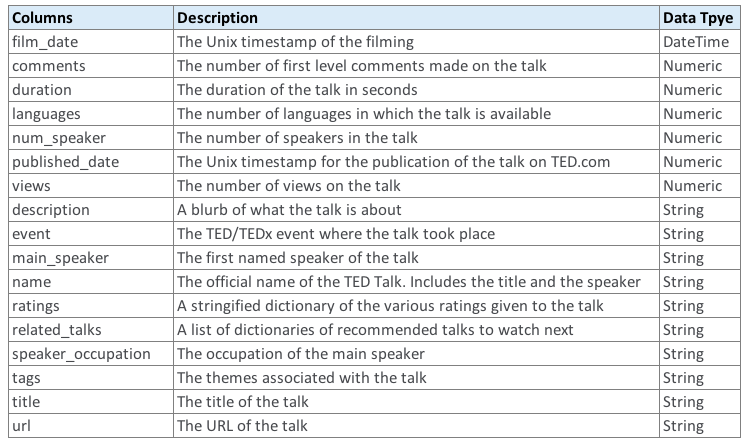

In [1]:
from IPython.display import display, Image
Image("dataset1.png")

### Dataset 2

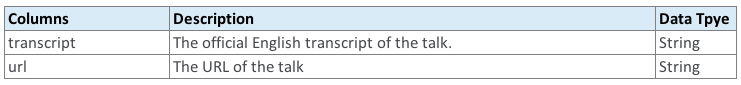

In [2]:
Image("dataset2.png")

### Dataset 3

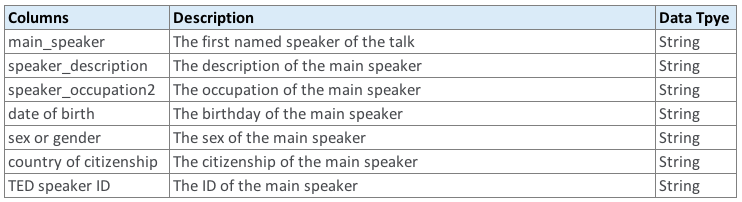

In [3]:
Image("dataset3.png")

# 2. Data Processing

In [4]:
import pandas as pd
import numpy as np
import re
import ast
from collections import defaultdict
import itertools
import datetime as dt
%pylab inline
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML
from textblob import Word
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import euclidean_distances

Populating the interactive namespace from numpy and matplotlib


In [5]:
pd.set_option('max_columns', 40)
pd.set_option('colwidth', 300)

## 2-1 Explore 3 datasets and drop duplicated rows.

__For dataset 1, only speakers occupation column has null values, so we replaced them with 'unknown'. For dataset 2, there is no null value. For dataset 3, we decided to keep null value because we planned to do some descriptive analysis about the speakers further without being influenced by null value. After that, we dropped duplicated rows for the three datasets.__

In [6]:
# Read the dataset.
df1= pd.read_csv('ted_main.csv')
df2= pd.read_csv('transcripts.csv')
df3= pd.read_html('https://www.wikidata.org/wiki/Wikidata:TED/TED_speakers',header=0)[0].drop('image',axis=1)

In [7]:
df1.head(1)

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views
0,4553,Sir Ken Robinson makes an entertaining and profoundly moving case for creating an education system that nurtures (rather than undermines) creativity.,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {'id': 1, 'name': 'Beautiful', 'count': 4573}, {'id': 9, 'name': 'Ingenious', 'count': 6073}, {'id': 3, 'name': 'Courageous', 'count': 3253}, {'id': 11, 'name': 'Longwinded', 'count': 387}, {'id': 2, 'name': 'Confusing', 'count': 242}, {'id': 8, 'name...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/images/ted/172559_800x600.jpg', 'speaker': 'Ken Robinson', 'title': 'Bring on the learning revolution!', 'duration': 1008, 'slug': 'sir_ken_robinson_bring_on_the_revolution', 'viewed_count': 7266103}, {'id': 1738, 'hero': 'https://pe.tedcdn.com/images/...",Author/educator,"['children', 'creativity', 'culture', 'dance', 'education', 'parenting', 'teaching']",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_schools_kill_creativity\n,47227110


In [8]:
# Check if there is any null.
df1.isnull().sum()

comments              0
description           0
duration              0
event                 0
film_date             0
languages             0
main_speaker          0
name                  0
num_speaker           0
published_date        0
ratings               0
related_talks         0
speaker_occupation    6
tags                  0
title                 0
url                   0
views                 0
dtype: int64

In [9]:
# Only speaker_occupation has null. Substitute null with unknown.
df1['speaker_occupation'].fillna('unknown', inplace = True)

In [10]:
df2.head(2)

,transcript,url
0,"Good morning. How are you?(Laughter)It's been great, hasn't it? I've been blown away by the whole thing. In fact, I'm leaving.(Laughter)There have been three themes running through the conference which are relevant to what I want to talk about. One is the extraordinary evidence of human creativi...",https://www.ted.com/talks/ken_robinson_says_schools_kill_creativity\n
1,"Thank you so much, Chris. And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful. I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night. And I say that sincere...",https://www.ted.com/talks/al_gore_on_averting_climate_crisis\n


In [11]:
# Check if there is any null.
df2.isnull().sum()

transcript    0
url           0
dtype: int64

In [12]:
df3.head(2)

,Name,description,occupation,date of birth,sex or gender,country of citizenship,TED speaker ID
0,A. J. Jacobs,American journalist and author,writer journalist,1968-03-20,male,United States of America,a_j_jacobs
1,Aakash Odedra,choreographer,choreographer,NaN,male,United Kingdom,aakash_odedra


In [13]:
# Drop duplicated rows.
df1.drop_duplicates(inplace=True)
df2.drop_duplicates(inplace=True)
df3.drop_duplicates(inplace=True)

In [14]:
# Rename similiar columns with df1 and df2 in df3
df3.rename(index=str, columns={'Name': 'main_speaker', 'description': 'speaker_description',
                             'occupation':'speaker_occupation2'}, inplace=True)

In [15]:
df3.head(2)

,main_speaker,speaker_description,speaker_occupation2,date of birth,sex or gender,country of citizenship,TED speaker ID
0,A. J. Jacobs,American journalist and author,writer journalist,1968-03-20,male,United States of America,a_j_jacobs
1,Aakash Odedra,choreographer,choreographer,NaN,male,United Kingdom,aakash_odedra


## 2-2 Merge 3 datasets.

__After inspecting our three datasets, we planned to merge dataset 1 and dataset 2 on URL columns and merge dataset 3 with dataset 1 on main speaker name columns. For dataset 1 and dataset 2, URL columns are all unique. However, we found that there are two names duplicated in dataset 3.  The duplicated value in key columns will cause problems while merging datasets. Comparing occupation of these four speakers, we found that they are different people. Therefore, after we merge these three datasets, we dropped incorrect rows based on the speaker names and their occupations.__


In [16]:
# Check the duplicated rows.
print('df1-url duplicated rows: ',df1.duplicated(subset='url').sum())
print('df2-url duplicated rows: ',df2.duplicated(subset='url').sum())
print('df3-main_speaker duplicated rows: ',df3.duplicated(subset='main_speaker').sum())

df1-url duplicated rows:  0
df2-url duplicated rows:  0
df3-main_speaker duplicated rows:  2


In [17]:
# Check if the is speakers with the same name and their videos.
a = df3['main_speaker'][df3.duplicated('main_speaker')]
df3[df3['main_speaker'].isin(a)]

,main_speaker,speaker_description,speaker_occupation2,date of birth,sex or gender,country of citizenship,TED speaker ID
326,Chris Anderson,American author and entrepreneur,journalist blogger,1961-07-09,male,United States of America,chris_anderson_wired
327,Chris Anderson,curator of TED,journalist,1957,male,United Kingdom,chris_anderson_ted
1279,Michael Green,architect,architect,NaN,male,NaN,michael_green
1280,Michael Green,social progress expert; created the Social Progress Index,NaN,NaN,male,NaN,michael_green_spi


In [18]:
# Merge the dataset into df5.
df4 = pd.merge(df1,df2,how='inner',on='url')
df5 = pd.merge(df4,df3, how='left', on='main_speaker')

In [19]:
df5[df5['main_speaker'].isin(a)][['main_speaker','title','speaker_occupation',
                                  'speaker_occupation2','speaker_description']]

,main_speaker,title,speaker_occupation,speaker_occupation2,speaker_description
98,Chris Anderson,Technology's long tail,Drone maker,journalist blogger,American author and entrepreneur
99,Chris Anderson,Technology's long tail,Drone maker,journalist,curator of TED
182,Chris Anderson,TED's nonprofit transition,TED Curator,journalist blogger,American author and entrepreneur
183,Chris Anderson,TED's nonprofit transition,TED Curator,journalist,curator of TED
734,Chris Anderson,How web video powers global innovation,TED Curator,journalist blogger,American author and entrepreneur
735,Chris Anderson,How web video powers global innovation,TED Curator,journalist,curator of TED
1461,Michael Green,Why we should build wooden skyscrapers,Architect,architect,architect
1462,Michael Green,Why we should build wooden skyscrapers,Architect,NaN,social progress expert; created the Social Progress Index
1781,Michael Green,What the Social Progress Index can reveal about your country,Social progress expert,architect,architect
1782,Michael Green,What the Social Progress Index can reveal about your country,Social progress expert,NaN,social progress expert; created the Social Progress Index


In [20]:
# Drop wrong merging rows.
df5.drop([1462,1781,1984,99,182,734,2109],inplace=True)

In [21]:
df5.reset_index(drop=True,inplace=True)

## 2-3 Change date columns from Unix timestamp to human dates.

__The original film dates and published dates are in Unix timestamp. We changed them into human dates, extracted the years and count the days from now to published days.__

In [22]:
# Original filme_date and publish_date are Unix timestamp.
df5[['film_date','published_date']].head()

,film_date,published_date
0,1140825600,1151367060
1,1140825600,1151367060
2,1140739200,1151367060
3,1140912000,1151367060
4,1140566400,1151440680


In [23]:
# Convert them into human date.
df5['film_date'] = df5['film_date'].apply(lambda x: dt.datetime.fromtimestamp(int(x)).strftime('%Y-%m-%d'))
df5['published_date'] = df5['published_date'].apply(lambda x: dt.datetime.fromtimestamp(int(x)).strftime('%Y-%m-%d'))

In [24]:
# Extract published year from dates.
df5['published_year'] = pd.DatetimeIndex(df5['published_date']).year

In [25]:
# Calculate number of days from now.
df5['published_days'] = df5['published_date'].apply(lambda x: (dt.datetime.now() - dt.datetime.strptime(x,'%Y-%m-%d')).days)

In [26]:
df5[['film_date','published_date','published_year','published_days']].head()

,film_date,published_date,published_year,published_days
0,2006-02-24,2006-06-26,2006,4343
1,2006-02-24,2006-06-26,2006,4343
2,2006-02-23,2006-06-26,2006,4343
3,2006-02-25,2006-06-26,2006,4343
4,2006-02-21,2006-06-27,2006,4342


## 2-4 Calculate speaker age when they addressed the speech.

__Frist, we extracted those whose birthday is neither in yyyy-mm-dd format (by regular expression) nor null. Most of them are composed of yyyy only. The special thing is some of the value ends with 's'. After researching these speakers online, we found only values with '2000s' are incorrect, so we replace them with null value. Then, we extracted the years of the speakers' birthday and the year they addressed their speeches and finally got the age when they addressed the speech. Last, we cut their age into 5-year intervals.
__

In [27]:
df5['date of birth'].head()

0    1950-03-04
1    1948-03-31
2    1963-03-09
3    1966-10-27
4    1948-07-27
Name: date of birth, dtype: object

In [28]:
# Rows tih completed value of 'date of birth'.
pat = '\d{4}-\d{2}-\d{2}'
a = df5['date of birth'].apply(lambda x: bool(re.match(pat,str(x)))) | df5['date of birth'].isnull()

In [29]:
# Other kinds of value in 'date of birth'.
b = df5[~a][['date of birth','main_speaker']]
b

,date of birth,main_speaker
16,1990,Jennifer Lin
18,1958,Ross Lovegrove
20,1965,Richard Baraniuk
25,1953,David Deutsch
31,1985,Eva Vertes
41,1930,Robert Fischell
48,1966,Rives
53,1942,Phil Borges
57,1959,Charles Leadbeater
59,1974,Saul Griffith


In [30]:
# Rows end with 's' in date of birth.
b[b['date of birth'].str.endswith("s")][['date of birth','main_speaker']]

,date of birth,main_speaker
192,1960s,Joseph Lekuton
222,1953s,Michael Moschen
365,1901s,Jamais Cascio
496,1953s,Joshua Silver
529,2000s,Paul Debevec
558,1940s,Marc Pachter
877,1901s,Susan Lim
879,2000s,Kathryn Schulz
933,1960s,Robert Hammond
934,1972s,Matt Cutts


In [31]:
# Replace 2000s with na value, because those are incorrect.
df5['date of birth'] = df5['date of birth'].replace('2000s',np.nan)

In [32]:
# Extract birth year from date of birth and use film date to calculate speakers' age (when they were making the speach). 
df5['birth year'] = df5['date of birth'].str[0:4]
df5['speaker_age'] = (df5['film_date'].str[0:4].astype(int)-df5['birth year'].astype(float))

In [33]:
# Create age group for speaker age.
age = list(range(10,120,5))
df5['age_group'] = pd.cut(df5['speaker_age'], bins=age)

In [34]:
df5[['date of birth','speaker_age','age_group']].head()

,date of birth,speaker_age,age_group
0,1950-03-04,56.0,"(55, 60]"
1,1948-03-31,58.0,"(55, 60]"
2,1963-03-09,43.0,"(40, 45]"
3,1966-10-27,40.0,"(35, 40]"
4,1948-07-27,58.0,"(55, 60]"


## 2-5 Clean country of citizenship column.

In [35]:
df5['country of citizenship'].head()

0              United Kingdom
1    United States of America
2    United States of America
3    United States of America
4                      Sweden
Name: country of citizenship, dtype: object

In [36]:
df5['country of citizenship'] = df5['country of citizenship'].str.replace('United Kingdom','/United Kingdom/').str.replace('United States of America','/United States of America/')


## 2-6 Clean transcript column.

__We planned to analysis transcript column further. Therefore, we changed all the words into lower case, removed punctuations, stop words, words appear more than 100 times and words appear less than 100 times. Last, we lemmatized the words. __

In [37]:
df5['transcript'].head(1)

0    Good morning. How are you?(Laughter)It's been great, hasn't it? I've been blown away by the whole thing. In fact, I'm leaving.(Laughter)There have been three themes running through the conference which are relevant to what I want to talk about. One is the extraordinary evidence of human creativi...
Name: transcript, dtype: object

In [38]:
# Lower case and remove punctuation.
df5['transcript'] = df5['transcript'].str.lower().replace("[()]",' ',regex = True).str.replace('[^\w\s]','')

In [39]:
# Remove stop word.
stop = stopwords.words('english')
df5['transcript'] = df5['transcript'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [40]:
# Remove common word.
freq = pd.Series(' '.join(df5['transcript']).split()).value_counts()[:100]
freq = list(freq.index)
df5['transcript'] = df5['transcript'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))

In [41]:
# Remove rare word.
freq = pd.Series(' '.join(df5['transcript']).split()).value_counts()[-100:]
freq = list(freq.index)
df5['transcript'] = df5['transcript'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))

In [42]:
# Lemmatization.
df5['transcript'] = df5['transcript'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

## 2-7 Transformed rating column into a normalized table.


__The value of rating column is composed of dictionaries. There are 14 different tags in this column, which corresponding to counts that the audiences vote for. We extracted the tags and the counts into a new data. The columns are tags and the rows are videos. Because the volume of each tag varies a lot, we normalized them into comparable value.__

In [43]:
df5['ratings'].head(1)

0    [{'id': 7, 'name': 'Funny', 'count': 19645}, {'id': 1, 'name': 'Beautiful', 'count': 4573}, {'id': 9, 'name': 'Ingenious', 'count': 6073}, {'id': 3, 'name': 'Courageous', 'count': 3253}, {'id': 11, 'name': 'Longwinded', 'count': 387}, {'id': 2, 'name': 'Confusing', 'count': 242}, {'id': 8, 'name...
Name: ratings, dtype: object

In [44]:
# Transform string format into dictionary format.
df5['ratings'] = df5['ratings'].apply(lambda x: eval(str(x))) 

In [45]:
# Extract ratings as new table.
dfx = pd.DataFrame(data=df5['ratings'][0],columns=('name', 'count')).set_index('name').T
for i in range(len(df5['ratings'])):
    dfx_row=pd.DataFrame(data=df5['ratings'][i],columns=('name', 'count')).set_index('name').T
    dfx=pd.concat([dfx, dfx_row], axis=0)
dfx = dfx[1:]
dfx = dfx.reset_index(drop=True)
dfx['Sum'] = dfx.sum(axis=1)
dfx.head()

,Beautiful,Confusing,Courageous,Fascinating,Funny,Informative,Ingenious,Inspiring,Jaw-dropping,Longwinded,OK,Obnoxious,Persuasive,Unconvincing,Sum
0,4573,242,3253,10581,19645,7346,6073,24924,4439,387,1174,209,10704,300,93850
1,58,62,139,132,544,443,56,413,116,113,203,131,268,258,2936
2,60,27,45,166,964,395,183,230,54,78,146,142,230,104,2824
3,291,32,760,132,59,380,105,1070,230,53,85,35,460,36,3728
4,942,72,318,4606,1390,5433,3202,2893,3736,110,248,61,2542,67,25620


In [46]:
# Normalized the whole tags table.
dtag = dfx.drop('Sum',axis=1).T
dtag_norm = (dtag - dtag.mean()) / (dtag.max() - dtag.min())

In [47]:
dtag_norm.T.head()

,Beautiful,Confusing,Courageous,Fascinating,Funny,Informative,Ingenious,Inspiring,Jaw-dropping,Longwinded,OK,Obnoxious,Persuasive,Unconvincing
0,-0.086206,-0.261443,-0.139614,0.156886,0.523626,0.025993,-0.025514,0.737221,-0.091627,-0.255576,-0.223733,-0.262779,0.161862,-0.259097
1,-0.310890,-0.302693,-0.144906,-0.159251,0.685012,0.478044,-0.314988,0.416569,-0.192037,-0.198185,-0.013759,-0.161300,0.119438,0.098946
2,-0.151243,-0.186461,-0.167251,-0.038116,0.813539,0.206281,-0.019973,0.030188,-0.157646,-0.132032,-0.059460,-0.063729,0.030188,-0.104284
3,0.023810,-0.225709,0.475640,-0.129370,-0.199697,0.109551,-0.155381,0.774291,-0.034957,-0.205478,-0.174649,-0.222819,0.186623,-0.221855
4,-0.165302,-0.327252,-0.281459,0.516754,-0.081906,0.670700,0.255398,0.197878,0.354803,-0.320179,-0.294490,-0.329300,0.132539,-0.328183


## 2-8 Clean up and transform speaker occupation column into a new table.

__The occupations of the speakers vary a lot. Some of them have two occupations, for example, author and educator. Some of them are in the same occupation with a different domain, for example, multimedia artist and artist. Therefore, we used bi-gram to count the number of speakers of each occupation and saved as a Document-term matrix. After that, we counted the number of each occupation, retrieved the total number of the views and calculated the average views for each occupation.__

In [48]:
df5['speaker_occupation'].head()

0                         Author/educator
1                        Climate advocate
2                    Technology columnist
3      Activist for environmental justice
4    Global health expert; data visionary
Name: speaker_occupation, dtype: object

In [ ]:
# Convert characters into lower one,  remove anything other than word characters and space, and lemmatized the words.
df5['speaker_occupation'] = df5['speaker_occupation'].str.lower().str.replace('[^\w\s]','')
df5['speaker_occupation'] = df5['speaker_occupation'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [49]:
# Calculate term frequency, tokenize by bigram and turn into dataframe. 
a = CountVectorizer(ngram_range=(1,2),stop_words="english")
b = a.fit_transform(df5['speaker_occupation']).toarray()
c = a.get_feature_names()
b = pd.DataFrame(b,columns=c)
z = pd.DataFrame(df5.index)
b = pd.concat([b,z],axis=1)
b = b.set_index(0)
del b.index.name

In [50]:
# After merging the dataframe with title, views and published_year, calculate counts and average views.
aa = pd.concat([df5[['title','views','published_year']],b],join='inner',axis=1)
bb = b.multiply(aa['views'],axis=0).sum()
cc = b.sum()
dd = pd.concat([cc,bb],axis=1)
dd.rename(index=str, columns={0: 'counts', 1: 'views'}, inplace=True)
dd['avg_views'] = dd['views']/dd['counts']
dd = dd[dd['counts']>=15]

In [51]:
speaker_table = dd

In [52]:
speaker_table.head(5)

,counts,views,avg_views
activist,141,201397270,1.428349e+06
actor,19,39519817,2.079990e+06
advocate,49,61525409,1.255621e+06
anthropologist,17,36199299,2.129371e+06
architect,44,57216254,1.300369e+06


## 2-9 Transform tags column into a new table.

__The tags of the videos are in list type. We transformed them into a Document-term matrix (DTM). Using this DTM, we counted the number of each tag, counted the total views and calculated the average views for each tag.
__

In [53]:
df5['tags'].head(1)

0    ['children', 'creativity', 'culture', 'dance', 'education', 'parenting', 'teaching']
Name: tags, dtype: object

In [54]:
# Calculate term frequency, tokenize by bigram and turn into dataframe. 
a = CountVectorizer()
b = a.fit_transform(df5['tags']).toarray()
c = a.get_feature_names()
b = pd.DataFrame(b,columns=c)
z = pd.DataFrame(df5.index)
b = pd.concat([b,z],axis=1)
b = b.set_index(0)
del b.index.name

In [55]:
# After merging the dataframe with title, views and published_year, calculate counts and average views.
aa = pd.concat([df5[['title','views','published_year']],b],join='inner',axis=1)
bb = b.multiply(aa['views'],axis=0).sum()
cc = b.sum()
dd = pd.concat([cc,bb],axis=1)
dd.rename(index=str, columns={0: 'counts', 1: 'views'}, inplace=True)
dd['avg_views'] = dd['views']/dd['counts']
dd = dd[dd['counts']>=50]

In [56]:
tags_table = dd

In [57]:
tags_table.head(5)

,counts,views,avg_views
activism,155,182116671,1.174946e+06
africa,101,115231152,1.140902e+06
animals,109,149805737,1.374365e+06
architecture,80,91462870,1.143286e+06
art,283,354083426,1.251178e+06


## 2-10 Transform related talks column into a new table.

__The value of related talks column is in dictionary type. We created a new table to record the recommended videos and their source videos.__

In [58]:
df5['related_talks'].head(1)

0    [{'id': 865, 'hero': 'https://pe.tedcdn.com/images/ted/172559_800x600.jpg', 'speaker': 'Ken Robinson', 'title': 'Bring on the learning revolution!', 'duration': 1008, 'slug': 'sir_ken_robinson_bring_on_the_revolution', 'viewed_count': 7266103}, {'id': 1738, 'hero': 'https://pe.tedcdn.com/images/...
Name: related_talks, dtype: object

In [59]:
# Expand the related talks into different rows.
rec = pd.DataFrame(columns=['from','to'])
for j in range(len(df5)):
    for i in eval(df5.loc[j,'related_talks']):
        rec = rec.append({'from': df5.loc[j,'title'], 'to':i.get('title')}, ignore_index=True)

In [60]:
rec.head(10)

,from,to
0,Do schools kill creativity?,Bring on the learning revolution!
1,Do schools kill creativity?,How to escape education's death valley
2,Do schools kill creativity?,"How to fix a broken school? Lead fearlessly, love hard"
3,Do schools kill creativity?,Education innovation in the slums
4,Do schools kill creativity?,A short intro to the Studio School
5,Do schools kill creativity?,How America's public schools keep kids in poverty
6,Averting the climate crisis,New thinking on the climate crisis
7,Averting the climate crisis,The business logic of sustainability
8,Averting the climate crisis,The state of the climate — and what we might do about it
9,Averting the climate crisis,A climate solution where all sides can win


# 3. Descriptive Analysis

__In this part, first, we explored some interesting relationships in our dataset. Next, we dug into our data to find the information that is closely related to views because we believe the number of views is a strong indicator of how influential a video is. We came up with six questions to explore our dataset.__

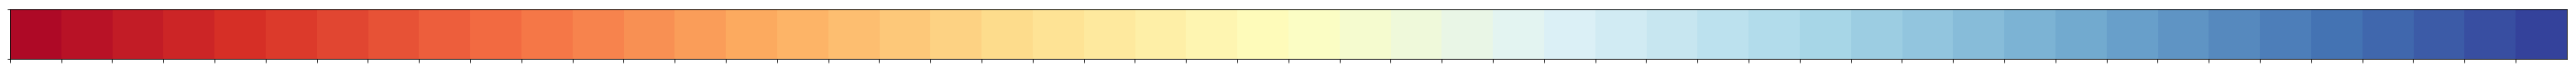

In [61]:
#The color for plotting
sns.palplot(sns.color_palette("RdYlBu", 50))
rdbu=sns.color_palette("RdYlBu", 50)

## 3-1 What is the distribution of age and gender of the speakers?

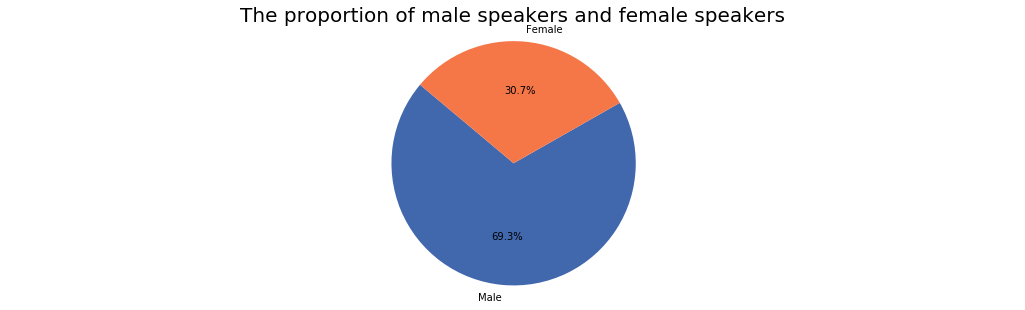

In [106]:
# The proportion of male speakers and female speakers
plt.subplots(figsize=(18,5))
plt.pie([df5[df5['sex or gender']=='male']['sex or gender'].count(),df5[df5['sex or gender']=='female']['sex or gender'].count()], 
        labels=['Male','Female'], autopct='%1.1f%%',startangle=140, colors=[rdbu[46],rdbu[10]])
plt.axis('equal')
plt.title('The proportion of male speakers and female speakers', size=20);

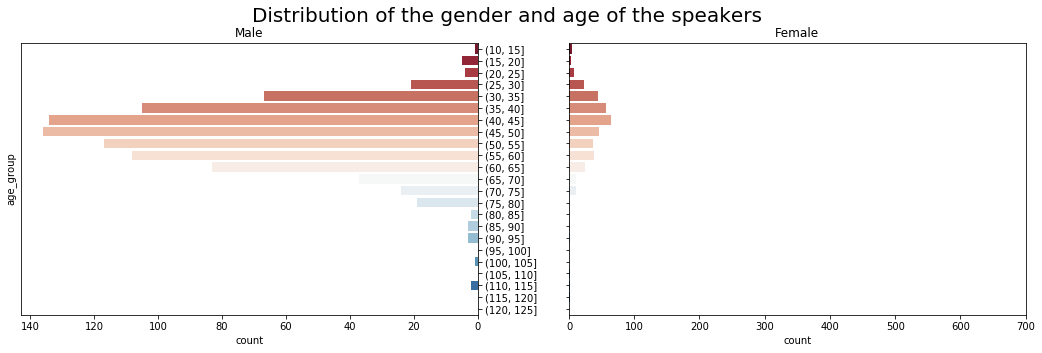

In [96]:
# The pyramid plot for age distribution of speakers’ by gender 
fig, axes = plt.subplots(ncols=2, sharey=True,figsize=(18,5))
sns.countplot(y=df5[df5['sex or gender']=='male']['age_group'].dropna(), ax=axes[0], palette='RdBu')
sns.countplot(y=df5[df5['sex or gender']=='female']['age_group'].dropna(), ax=axes[1], palette='RdBu')
plt.xlim((0,700))
axes[0].invert_xaxis()
axes[0].yaxis.tick_right()
axes[0].set_title("Male")
axes[1].set_title("Female")
axes[0].set(xlabel="count", ylabel='age_group') 
axes[1].set(xlabel="count", ylabel="")
fig.suptitle("Distribution of the gender and age of the speakers", size=20);

__From the pie chart, we can clearly see that the proportion of the gender of the speakers is significantly unbalanced. Only 30.7% of the speakers are female while 69.3% of the speakers are male.__

__In general, the speakers' age distribution of both genders are similiar. The age group taking up highest proportion for men are between 45 and 50, while women are between 40 and 45.__

## 3-2 What kind of occupations of the speakers receive more views on average? 

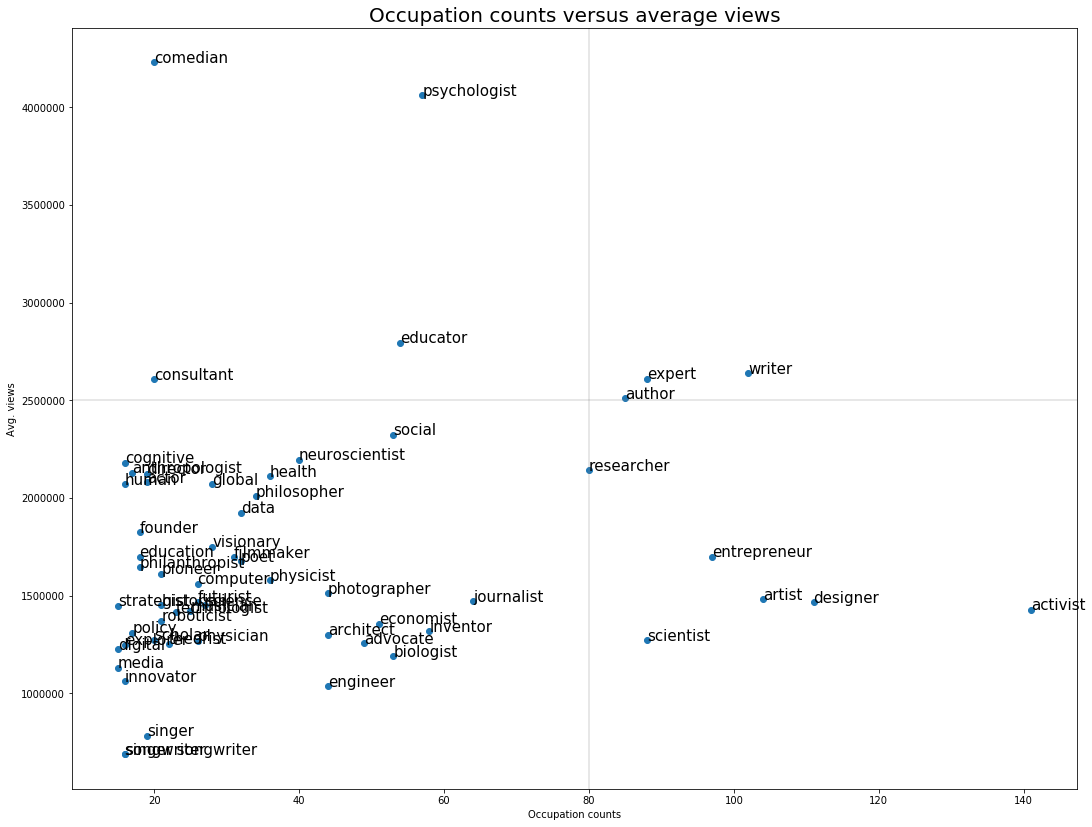

In [111]:
# Plot the speaker_table into scatter plot.
y = speaker_table['avg_views']
z = speaker_table['counts']
n = list(speaker_table.index)

fig, ax = plt.subplots(figsize=(18,14))
ax.scatter(z, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i],y[i]),size=15)
plt.xlabel('Occupation counts')
plt.ylabel('Avg. views')
plt.title('Occupation counts versus average views', size=20);
plt.axhline(2500000, c='0.5', alpha=0.25);
plt.axvline(80, c='0.5', alpha=0.25);

__
From this plot, we can see that the activist are the largest group of the occupation. The occupation is dispersed. Psychologist,  comedian, educator and consultant on average get the highest views. For TED, they could invite more speakers of the occupations in the second quadrant. The occupations fell in the second quadrant mean the audience is more interested in such speech addressed by these occupations but were less provided by the TED.__

## 3-3 What kind of topics receive more views on average?  

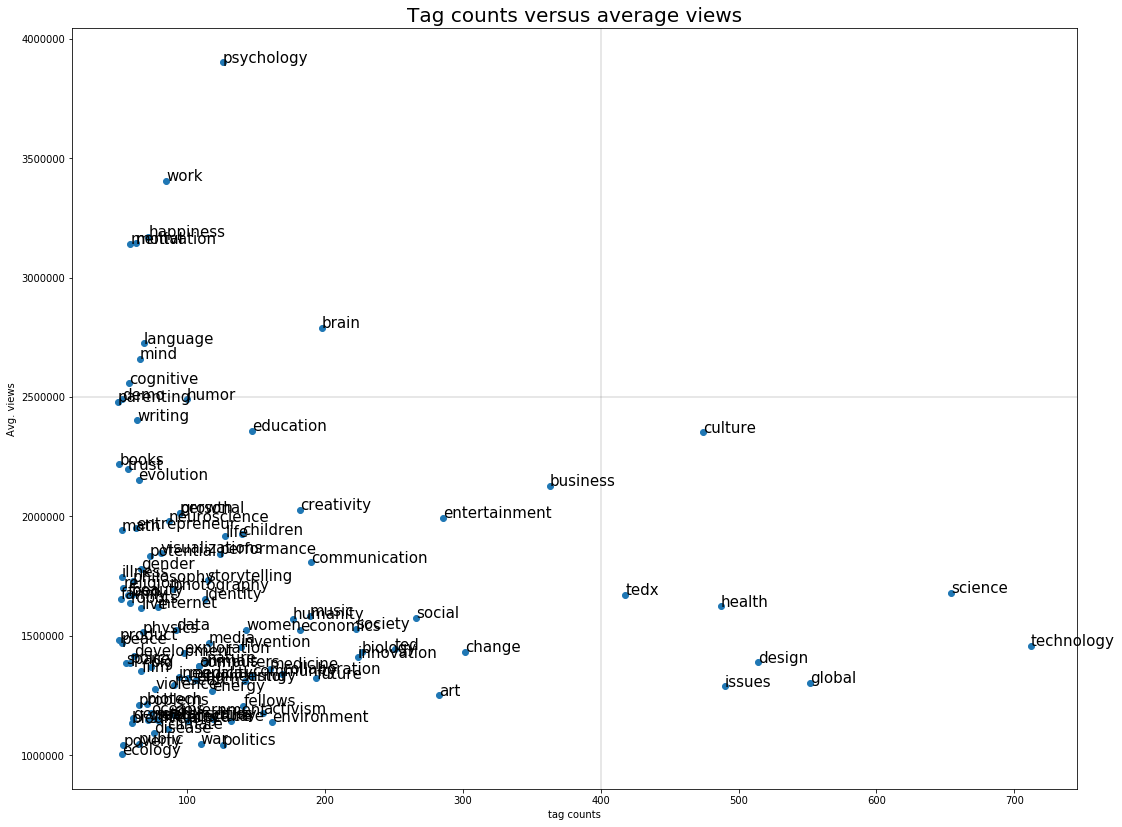

In [112]:
# Plot the tags_table into scatter plot.
y = tags_table['avg_views']
z = tags_table['counts']
n = list(tags_table.index)

fig, ax = plt.subplots(figsize=(18,14))
ax.scatter(z, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i],y[i]),size=15)
plt.xlabel('tag counts')
plt.ylabel('Avg. views')
plt.title('Tag counts versus average views', size=20);
plt.axhline(2500000, c='0.5', alpha=0.25);
plt.axvline(400, c='0.5', alpha=0.25);

## 3-4 Top 10% of videos contributes to 38.6% of the views.

In [66]:
#Find the videos with top 10 views
a= df5['views'].sort_values(ascending=False).iloc[int(len(df5)*0.1)]
pop = df5['views'] > a

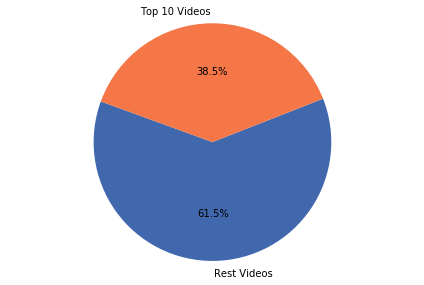

In [67]:
#Plot the pie chart for the total views of top 10 videos and other videos.
plt.pie([df5[~pop]['views'].sum(),df5[pop]['views'].sum()],labels=['Rest Videos', "Top 10 Videos"], 
        autopct='%1.1f%%',startangle=160,colors=[rdbu[46],rdbu[10]])
plt.axis('equal')
plt.tight_layout()

## 3-5 Does a video with longer duration get more views?

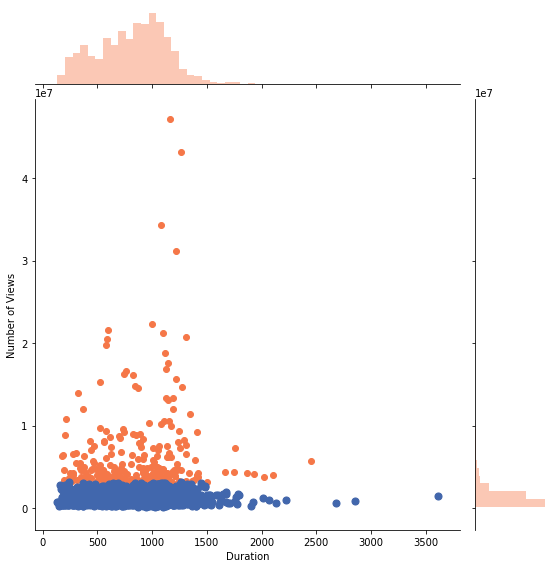

In [68]:
#Make a joint plot that using duratin as x axis, number of views of y axis, 
#and two different colors of points representing top10 videos and not.
graph = sns.jointplot(df5['duration'], y=df5['views'], color=rdbu[10],size=8,stat_func=None);
graph.x = df5[~pop]['duration']
graph.y = df5[~pop]['views']
graph.plot_joint(plt.scatter, marker='o', c=rdbu[46], s=50);
graph.set_axis_labels(xlabel='Duration', ylabel='Number of Views');

__According to the plot, we can not firmly detect a relationship between duration and views. Still, the plot tells us that videos with more than 250,000,000 views have the duration between 1000 and 1500 second (16-25 minutes).__

## 3-6 Does published time influence views?

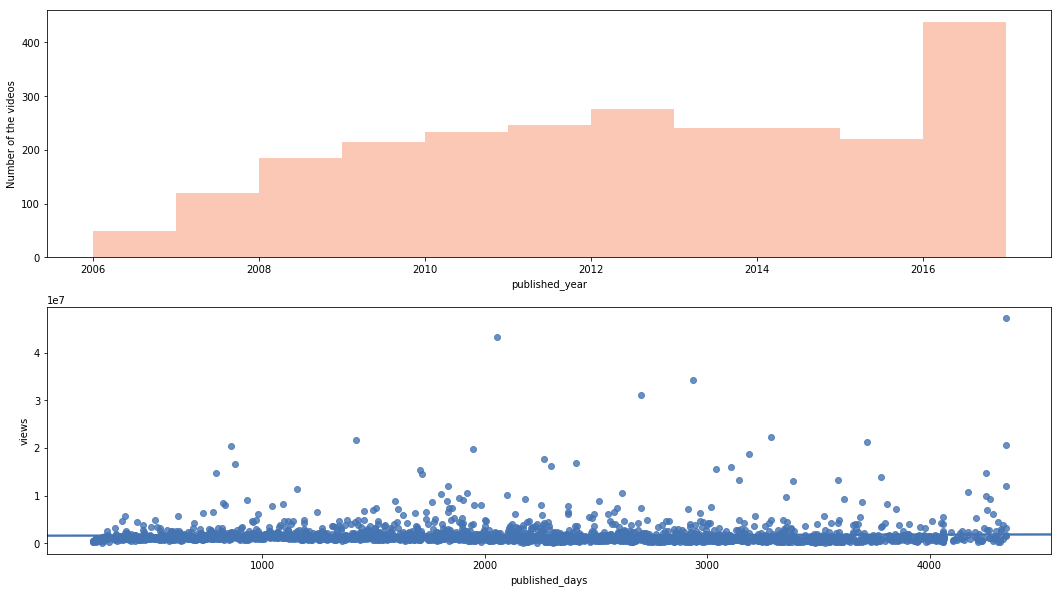

In [69]:
#Plot the number of videows in each year and the views with different published_days
fig, ax = pyplot.subplots(2,figsize=(18,10))
sns.distplot(df5['published_year'],bins=np.arange(2006,2018,1), kde=False, color=rdbu[10],ax=ax[0]);
ax[0].set_ylabel('Number of the videos');
sns.regplot(x=df5['published_days'], y=df5["views"],color=rdbu[45]);

__We can see that there is no obvious relationship between published days and views according to the plot. __

## 3-7 Does title starting with question sentence get more views?

In [70]:
# View the description of question-title versus non-question-title.
qs= df5['title'].apply(lambda x: x.lower().startswith(('do','does','are','is','has','have','how','who','what','when','where','why')))

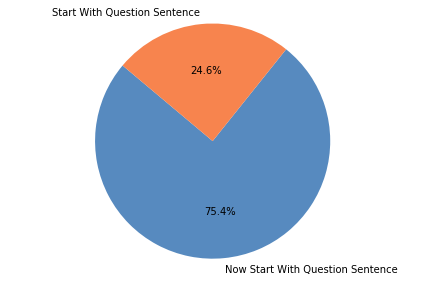

In [71]:
#The percentage of titles start with question sentence and those are not 
plt.pie([len(qs)-qs.sum(),qs.sum()],labels=['Now Start With Question Sentence', "Start With Question Sentence"], 
        autopct='%1.1f%%',startangle=140,colors=[rdbu[43],rdbu[11]])
plt.axis('equal')
plt.tight_layout()

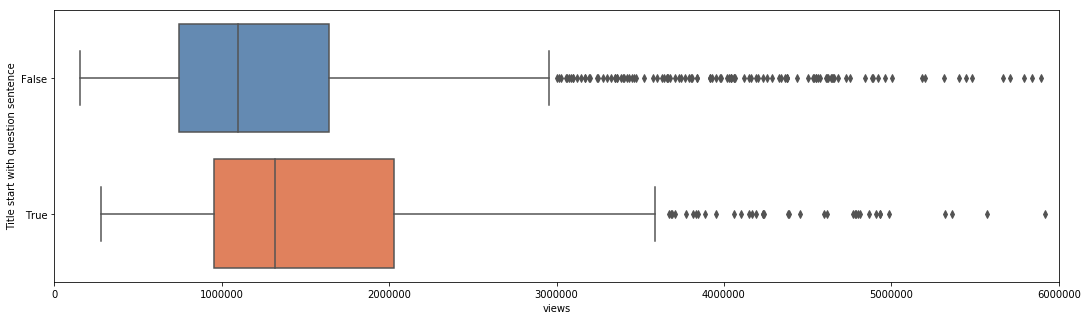

In [100]:
#The boxplot of the distribution of views with those titles starting with question sentecne titles and those are not
plt.figure(figsize=(18,5))
sns.boxplot(x=df5['views'], y=qs, orient='h',palette=[rdbu[43],rdbu[10]])
plt.xlim((0,6000000))
plt.ylabel('Title start with question sentence');

__From the box plots, we can see that videos with question sentence have a slightly higher median and a wider range of views. This might suggest that using a question sentence as titles is more likely to arouse attention. However, the relationship is very weak.__

## 3-8 Is there any relationship between the length of title and views?

In [73]:
#Count the length of title into new column
df5['title_length']= df5['title'].str.lower().str.replace('[^\w\s]','').str.split().apply(lambda x: len(x))

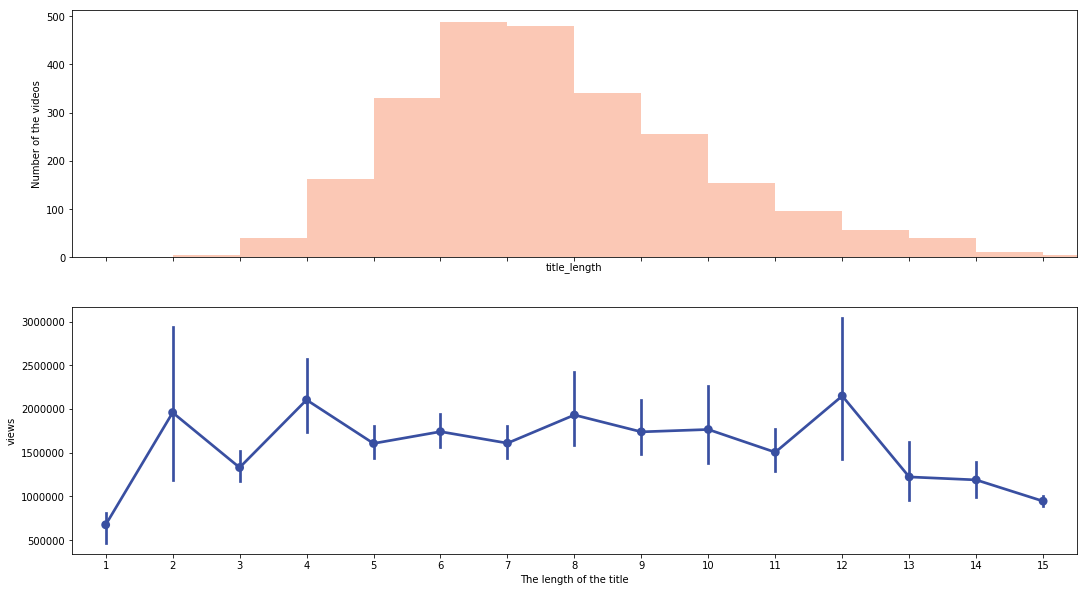

In [74]:
#Plot the graph of length of title and number of the videos and the total views with different length of titles 
fig, ax = pyplot.subplots(2,figsize=(18,10),sharex=True)
sns.distplot(df5['title_length'],bins=14, kde=False,color=rdbu[10], ax=ax[0])
ax[0].set_ylabel('Number of the videos');
sns.pointplot(x=df5['title_length'], y=df5['views'],color=rdbu[48]);
plt.xlabel('The length of the title');

__From this plot, we can see that there is no relationship between the length of the title and the number of views.__

## 3-9 Summary

__From the above exploration, we found that no matter how long the speech is, what time the video is published, or how long the title is, all of them has little or no influence to the number of views.__

__Therefore, we infer that the content dominates the number of views instead of the other factors.__

# 4. Prescriptive Analysis

__To improve the better user experience of TED website, we came up with three recommendations.__

## 4-1 Extract top 5 most representative words from the contents as hashtags.

__With these hashtags, users are able to know what the video is about within few seconds. Also, they can find videos by hashtags they are interested in. We transformed each transcript into TFIDF matrix and selected 5 words by their top 5 highest TFIDF.__

### An illustration of our concept

In [75]:
Image("hash.png")

In [76]:
#Create a Tfidf vectorizer for text
vectorizer = TfidfVectorizer(stop_words="english",
                             use_idf=True,
                             ngram_range=(1,2),  # considering 2-grams
                             min_df = 0.001,     # cut words present in less than 0.1% of documents
                             max_df = 0.5)       # cut words present in more than 50% of documents 
tfidf = vectorizer.fit_transform(df5['transcript'])

In [77]:
#Create a Tfidf matrix for hashtag
feature_array = np.array(vectorizer.get_feature_names())
tfidf_sorting = np.argsort(tfidf.toarray())[::-1]
n = 5
b= [i.argsort()[-n:][::-1] for i in tfidf.toarray()]
for i,j in enumerate(b):
    a=''
    for k in range(n):
        a= a+str(feature_array[j][k])+str(', ')
    df5.loc[i,'hashtags']=a[:-2]

In [78]:
# View the most popular videos with recommend
df5.sort_values(by=['views'],ascending=False)[['title','hashtags']].head()

,title,hashtags
0,Do schools kill creativity?,"education, gillian, shes, ballet, public education"
1265,Your body language may shape who you are,"lowpower, testosterone, cortisol, pose, minute"
649,How great leaders inspire action,"buy, wright, wright brother, langley, apple"
800,The power of vulnerability,"vulnerability, numb, shame, worthiness, belonging"
444,10 things you didn't know about orgasm,"orgasm, semen, reflex, sow, trigger"


## 4-2 Recommendation system - find top 5 similar videos according to the contents.


__Users sometimes find a topic so interesting after watching a TED video that they are eager to know more about it. In other words, users want more similar videos. Therefore, we came up an idea to find top 5 similar videos for each video base on their content. We transformed all the transcript into TFIDF and calculated the similarity using the Euclidean distance between two transcripts. This recommendation can be applied using their existing recommendation system.__

### An illustration of our concept

In [79]:
HTML('<iframe width="850" height="400" src="https://www.youtube.com/embed/7GbexvSi0qo?autoplay=1&loop=1&cc_load_policy=1rel=0&amp;controls=0&amp;showinfo=0&playlist=7GbexvSi0qo" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe>')

In [80]:
#Use euclidean_distances on tdifd to find the distance of different videos
a= euclidean_distances(tfidf)
n= 5
b= [i.argsort()[-n:][::-1] for i in a]
for i,j in enumerate(b):
    for k in range(n):
        df5.loc[i,('recommended_videos_'+str(k+1))]= df5.loc[j,'title'].values[k]

In [81]:
# View the most popular videos with recommend 
df5.sort_values(by=['views'],ascending=False)[['title','recommended_videos_1','recommended_videos_2','recommended_videos_3','recommended_videos_4','recommended_videos_5']].head()

,title,recommended_videos_1,recommended_videos_2,recommended_videos_3,recommended_videos_4,recommended_videos_5
0,Do schools kill creativity?,"""The Dog Song""","""La Vie en Rose""",Cape Breton fiddling in reel time,"You smell with your body, not just your nose",Print your own medicine
1265,Your body language may shape who you are,"A dance in a hurricane of paper, wind and light","Dance, tiny robots!",My magic moves,Dancing with light,An all-star set
649,How great leaders inspire action,A musical escape into a world of light and color,An all-star set,"On violin and cello, ""Passacaglia""","Dance, tiny robots!",My magic moves
800,The power of vulnerability,Dancing with light,My magic moves,"Dance, tiny robots!","A dance in a hurricane of paper, wind and light",An 11-year-old prodigy performs old-school jazz
444,10 things you didn't know about orgasm,My magic moves,"A dance in a hurricane of paper, wind and light",An electrifying acoustic guitar performance,A musical escape into a world of light and color,Dancing with light


## 4-3 Cluster videos into different topics based on their content.

__With the topics, users can explore videos according to the topics. We clustered all the videos into 7 groups by K-menas: Business, Global Issue, Business, Culture, Psychology, Environment and Education.__

### An illustration of our concept

In [82]:
Image("theme3.png")

In [83]:
#Create a Tfidf Vectorizer for K-menas clustering
vectorizer = TfidfVectorizer(stop_words="english",
                        use_idf=True,
                        ngram_range=(1,1), # considering only 1-grams
                        min_df = 0.15,     # cut words present in less than 5% of documents
                        max_df = 0.9) 
X = vectorizer.fit_transform(df5['transcript'])

In [84]:
#Build a k-means model
true_k = 7
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=1,random_state=2)
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=200,
    n_clusters=7, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=2, tol=0.0001, verbose=0)

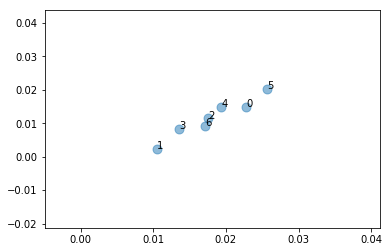

In [85]:
#Check the disctance between clustering centers and then decide a better number of clusters 
centers = model.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], cmap='Paired', s=80, alpha=0.5);
n=list(range(true_k))
for i, txt in enumerate(n):
    plt.annotate(txt, (centers[:, 0][i],centers[:, 1][i]))

In [86]:
#Create a table of with 7 clusters and the top 10 words in each cluster 
centers = model.cluster_centers_
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
cen=pd.DataFrame(centers)
Clusters=pd.DataFrame()
for i in range(true_k):
    ls=[]
    for ind in order_centroids[i, :10]:
        ls.append(str(terms[ind])+" "+str(cen[ind][i].round(2)))
    Clusters["Cluster %d" % i]=ls
Clusters.columns = ['Business', 'Global Issue', "Business", 'Culture', 'Psychology','Environment','Education']
Clusters

,Business,Global Issue,Business,Culture,Psychology,Environment,Education
0,country 0.1,music 0.62,brain 0.33,woman 0.45,city 0.1,water 0.16,kid 0.06
1,government 0.07,play 0.09,cell 0.28,men 0.16,design 0.09,animal 0.14,story 0.05
2,data 0.07,sound 0.09,body 0.08,girl 0.15,building 0.07,planet 0.11,child 0.05
3,company 0.06,thank 0.07,disease 0.07,mother 0.07,space 0.07,earth 0.1,love 0.05
4,dollar 0.05,piece 0.05,technology 0.05,child 0.06,machine 0.06,food 0.08,school 0.05
5,state 0.05,hear 0.05,animal 0.04,story 0.06,technology 0.06,place 0.05,word 0.04
6,health 0.05,end 0.04,lab 0.04,school 0.05,computer 0.06,light 0.04,feel 0.04
7,africa 0.05,yeah 0.03,information 0.04,family 0.05,car 0.06,area 0.04,mean 0.04
8,money 0.05,let 0.03,let 0.04,young 0.05,project 0.05,million 0.04,guy 0.04
9,global 0.05,voice 0.03,behavior 0.04,country 0.05,energy 0.05,foot 0.04,book 0.04


In [87]:
#Build a dictionary with clusters' number and name
df5['Cluster']=model.labels_
theme_d={}
for i in range(7):
    theme_d[i]=Clusters.columns[i]
theme_d

{0: 'Business',
 1: 'Global Issue',
 2: 'Business',
 3: 'Culture',
 4: 'Psychology',
 5: 'Environment',
 6: 'Education'}

In [88]:
#Insert the "theme" column that representing the clusters
df5['theme'] = df5['Cluster'].apply(lambda x: theme_d[x]) 
df5.sort_values(by=['views'],ascending=False)[['Cluster',"title",'theme']].head()

,Cluster,title,theme
0,6,Do schools kill creativity?,Education
1265,6,Your body language may shape who you are,Education
649,0,How great leaders inspire action,Business
800,6,The power of vulnerability,Education
444,3,10 things you didn't know about orgasm,Culture


# Conclusion

__In our descriptive analysis, we checked the relationship between views and some features, including speakers’ occupation, tags, duration, published time and titles.__

__What we have found are:__

- Female speakers are much less than male speakers.
- The videos of comedian and psychologist are not much but with high views; activists’ video is many but with lower views.
- The videos about psychology are not much but with high views; there are many videos about technology and science but the average views of them are not high.
- Top 10% of the videos takes up 38.6%.
- The duration of those videos with very high (more than 250,000,000) views is between 16 to 25 minutes.
- Published days might not contribute to views.
- A quarter of videos have titles that starting with question sentence; the titles starting with question sentence could have a very weak relationship to the views.
- There might not be a relationship between the length of the title and the number of views.

__With these findings, we suggest TED talks to:__

- Inviting more female speakers so as to balance the gender ratio of speakers.
- Arranging more comedians and psychologists to TED talks for.catering audience’s interests.
- Preparing more videos about psychology for meeting audience needs.
- Controlling the duration of TED talks between 16-25 minutes.
- Suggesting their speakers make their titles starting with question sentence if they are looking for advice.

__Although we did not find important features that related to the number of views after our analysis, we still might find the relationship and method to help to gain views if we get more data such as the accumulated views in each year of a video.__

__In the part of the prescriptive analysis, to help TED Talks users reaching out the videos easier, we created three systems, including videos hashtags, a recommendation system and theme clustering by text mining on transcripts. With videos hashtags, a user can easily find a video that meets his/her interests. The recommendation system is very useful when users are attracted by the topic of a video and want to learn more about the idea. Last but not least, theme clustering not only provides an easy way to organize videos for TED talks but also creates a friendly environment for the audience to find what they are looking for.__

__However, even though we can label theme for each video according to the cluster, we noticed that most of the videos are multi-theme. It will be more accurate and useful for users if we can find a better way to classify our videos with multiple labels.__


# Reference

‧ Dataset (Kaggle): https://www.kaggle.com/rounakbanik/ted-talks

‧ Wikidata: https://www.wikidata.org/wiki/Wikidata:TED/TED_speakers

‧ Design materials(wix): https://www.wix.com/

‧ Why protect our oceans?: https://marine-conservation.org/what-we-do/advocate/why-we-protect-our-oceans/